## Exploratory Data Analysis

In [46]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division




import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go


In [47]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install chart_studio

In [48]:
#Import Data
parse_dates = ['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'shipping_limit_date',
'review_creation_date',
 'review_answer_timestamp',]

OL_Data = pd.read_csv("./OL_Data_Order_Grouped.csv", 
                      parse_dates=parse_dates,
                      date_parser = pd.to_datetime)



OL_Data.dtypes


Unnamed: 0                                int64
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
payment_installments                    float64
product_category_name_english            object
seller_id                                object
seller_zip_code_prefix                  float64
seller_city                              object
seller_state                             object
seller_latitude                         float64
seller_longitude                        float64
customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                           

<h3>RFM Scoring</h3>

<h4>Functions</h4>

In [102]:
from sklearn.cluster import KMeans

def PrintKmeansInertiaGraph(dataFrame, column):
    PrintKmeansInertiaGraph(dataFrame, [column])
    
def PrintKmeansInertiaGraph(dataFrame, columns):
    sse={}
    columnDF = dataFrame[[columns]]
    
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(columnDF)
        columnDF.assign(clusters=kmeans.labels_)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()
    
def PerformKMeans(dataFrame, column, numClusters):
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(dataFrame[[column]])
    clusterCol = '{0}Cluster'.format(column)
    clusters = kmeans.predict(dataFrame[[column]])
    
    if(clusterCol in dataFrame.columns):
        dataFrame.loc[:,clusterCol] = clusters
    else:
        dataFrame[clusterCol] = clusters
    
    
#function for ordering cluster numbers
def clustersInOrder(clusterName, targetName, dataFrame, ascending):
    
    #Set New Labels on Clusters, 0-max in order of mean targetName Value
    df_new = dataFrame.groupby(clusterName)[targetName].mean().reset_index()
    df_new = df_new.sort_values(by=targetName,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    
    #Set New Labels of Clusters to 
    df_final = pd.merge(dataFrame,df_new[[clusterName,'index']], on=clusterName)
    df_final = df_final.drop([clusterName],axis=1)
    df_final = df_final.rename(columns={"index":clusterName})
    
    return df_final

<h3>Buyers</h3>

<h4>Recency</h4>

count    94466.000000
mean       241.855059
std        152.696186
min          0.000000
25%        118.000000
50%        223.000000
75%        350.000000
max        728.000000
Name: Buyer_Recency, dtype: float64


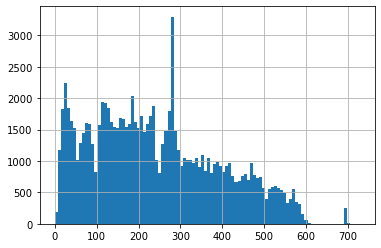

In [100]:
#Recency Score Calc
buyers = pd.DataFrame(OL_Data['customer_unique_id'].unique())
buyers.columns=['CustomerUniqueID']

buyerMaxPurchase = OL_Data.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
buyerMaxPurchase.columns = ['CustomerUniqueID', 'MaxPurchaseDate']

buyerMaxPurchase['Buyer_Recency'] = (buyerMaxPurchase['MaxPurchaseDate'].max() - buyerMaxPurchase['MaxPurchaseDate']).dt.days

buyers = pd.merge(buyers, buyerMaxPurchase[['CustomerUniqueID','Buyer_Recency']])

print(buyers['Buyer_Recency'].describe())
buyers.Buyer_Recency.sort_values().hist(bins=100)
plt.show()


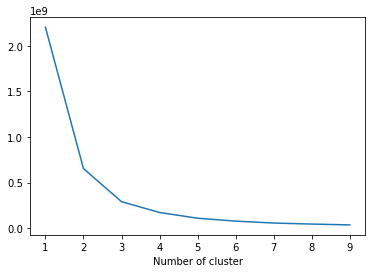

In [103]:
PrintKmeansInertiaGraph(buyers,'Buyer_Recency')

In [52]:
#Generate Recency Clusters, named 'RecencyCluster'
PerformKMeans(buyers,'Buyer_Recency', 4)

#Reset Cluster Names, Lower Recency = More Recent, Higher RecencyCluster
buyers = clustersInOrder('Buyer_RecencyCluster', 'Buyer_Recency', buyers, False)

count    94466.000000
mean         1.061006
std          0.289505
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: Buyer_Frequency, dtype: float64


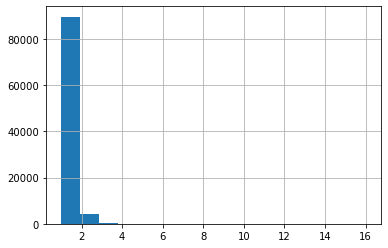

In [105]:
#Frequency
freq = OL_Data.groupby('customer_unique_id').order_id.count().reset_index()
freq.columns = ['CustomerUniqueID','Buyer_Frequency']
freq.head()

buyers = pd.merge(buyers,freq, on='CustomerUniqueID')

print(buyers['Buyer_Frequency'].describe())
buyers.Buyer_Frequency.sort_values().hist(bins=16)
plt.show()

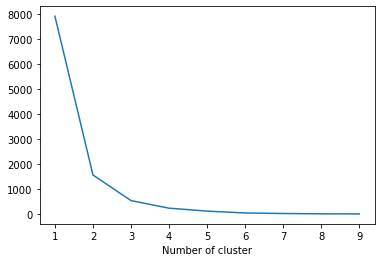

In [106]:
PrintKmeansInertiaGraph(buyers,'Buyer_Frequency')

In [55]:
#Generate Recency Clusters, named 'FrequencyCluster'
PerformKMeans(buyers,'Buyer_Frequency', 4)

#Reset Cluster Names, Higher Frequency = More Frequent, Higher Frequency Cluster
buyers = clustersInOrder('Buyer_FrequencyCluster', 'Buyer_Frequency', buyers, True)

count    94466.000000
mean       182.891840
std        306.675411
min          0.000000
25%         63.230000
50%        108.840000
75%        188.340000
max      13664.080000
Name: Buyer_Revenue, dtype: float64


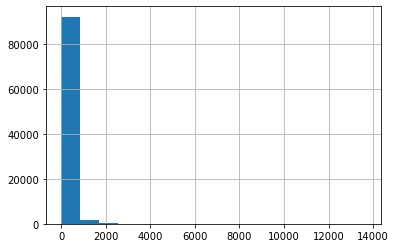

In [109]:
#Revenue
rev = OL_Data.groupby('customer_unique_id').Total_payment.sum().reset_index()
rev.columns = ['CustomerUniqueID','Buyer_Revenue']

buyers = pd.merge(buyers, rev, on='CustomerUniqueID')

print(buyers['Buyer_Revenue'].describe())
buyers.Buyer_Revenue.sort_values().hist(bins=16)
plt.show()

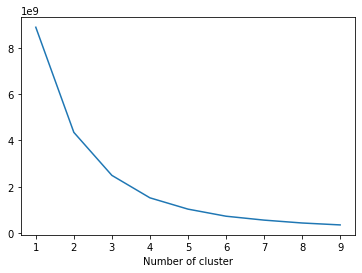

In [57]:
PrintKmeansInertiaGraph(buyers,'Buyer_Revenue')

In [110]:
#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(buyers,'Buyer_Revenue', 5)

#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
buyers = clustersInOrder('Buyer_RevenueCluster', 'Buyer_Revenue', buyers, True)

In [125]:
sub = buyers[['Buyer_Recency','Buyer_Frequency','Buyer_Revenue']]

sub = sub.assign(scale_recency=sub.apply(lambda x: 1 - x['Buyer_Recency']/sub['Buyer_Recency'].max(),axis=1))
sub = sub.assign(scale_frequency=sub.apply(lambda x: x['Buyer_Frequency']/sub['Buyer_Frequency'].max(),axis=1))
sub = sub.assign(scale_revenue=sub.apply(lambda x: 1 - x['Buyer_Revenue']/sub['Buyer_Revenue'].max(),axis=1))

sub.head()

,Buyer_Recency,Buyer_Frequency,Buyer_Revenue,scale_recency
0,335,2,82.82,0.539835
1,388,1,83.69,0.467033
2,417,1,52.77,0.427198
3,405,1,52.77,0.443681
4,379,1,44.00,0.479396


In [76]:
#calculate overall score and use mean() to see details
buyers['Buyer_OverallRFMScore'] = buyers['Buyer_RecencyCluster'] + buyers['Buyer_FrequencyCluster'] + buyers['Buyer_RevenueCluster']
buyers['Buyer_OverallRFM_Raw'] = buyers['Buyer_Recency'] + buyers['Buyer_Frequency'] + buyers['Buyer_Revenue']

print(buyers.groupby('Buyer_OverallRFMScore')[['Buyer_Recency','Buyer_Frequency','Buyer_Revenue']].mean())

print(buyers.groupby('Buyer_OverallRFMScore')[['Buyer_Revenue']].count())

                       Buyer_Recency  Buyer_Frequency  Buyer_Revenue
Buyer_OverallRFMScore                                               
0                         486.810518         1.000000      96.550975
1                         336.884431         1.011850     123.458073
2                         213.162732         1.029242     145.405261
3                          98.446981         1.046245     170.555545
4                         112.746388         1.276485     468.543032
5                         111.001871         1.660636     874.678153
6                         104.647940         2.183521    1422.505037
7                         101.842767         2.767296    2418.677736
8                          97.207547         4.150943    3225.849434
9                          69.083333         4.166667    4316.088333
                       Buyer_Revenue
Buyer_OverallRFMScore               
0                              13463
1                              21857
2                       

In [60]:
buyers['Buyer_RFM_Ranking'] = 'Lowest'
buyers.loc[buyers['Buyer_OverallRFMScore']>=1,'Buyer_RFM_Ranking'] ='Low' 
buyers.loc[buyers['Buyer_OverallRFMScore']>=3, 'Buyer_RFM_Ranking'] = 'Medium'
buyers.loc[buyers['Buyer_OverallRFMScore']>=6, 'Buyer_RFM_Ranking'] = 'High'
buyers.loc[buyers['Buyer_OverallRFMScore']>=8, 'Buyer_RFM_Ranking'] = 'Highest'

In [62]:
buyers.head()

,CustomerUniqueID,Buyer_Recency,Buyer_RecencyCluster,Buyer_Frequency,Buyer_FrequencyCluster,Buyer_Revenue,Buyer_RevenueCluster,Buyer_OverallRFMScore,Buyer_RFM_Ranking
0,7c396fd4830fd04220f754e42b4e5bff,335,1,2,1,82.82,0,2,Low
1,7973a6ba9c81ecaeb3d628c33c7c7c48,348,1,2,1,115.74,0,2,Low
2,0a5df23b922b9998bb7378f1ac03c98a,338,1,2,1,193.83,0,2,Low
3,95cfb39a7e263160308a934e42cfc4e0,287,1,2,1,122.05,0,2,Low
4,646d643b4ac1184e383341f8896c3dc8,286,1,2,1,178.04,0,2,Low


count    2977.000000
mean      134.126638
std       163.831359
min         0.000000
25%        17.000000
50%        46.000000
75%       210.000000
max       699.000000
Name: Seller_Recency, dtype: float64


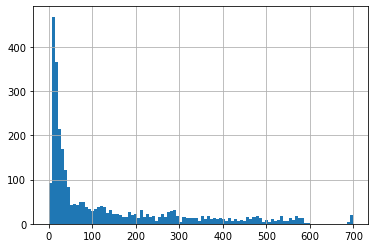

In [63]:
#Recency Score Calc
sellers = pd.DataFrame(OL_Data['seller_id'].unique())
sellers.columns=['SellerID']

sellerMaxSale = OL_Data.groupby('seller_id').order_purchase_timestamp.max().reset_index()
sellerMaxSale.columns = ['SellerID', 'MaxSaleDate']

sellerMaxSale['Seller_Recency'] = (sellerMaxSale['MaxSaleDate'].max() - sellerMaxSale['MaxSaleDate']).dt.days

sellers = pd.merge(sellers, sellerMaxSale[['SellerID','Seller_Recency']])

print(sellers['Seller_Recency'].describe())
sellers.Seller_Recency.sort_values().hist(bins=100)
plt.show()

count    2977.000000
mean       33.667786
std       108.081772
min         1.000000
25%         2.000000
50%         7.000000
75%        22.000000
max      1865.000000
Name: Seller_Frequency, dtype: float64


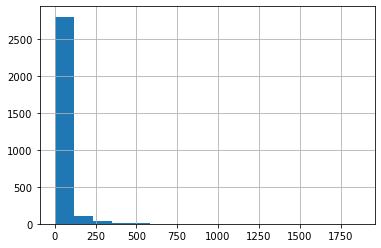

In [64]:
#Frequency
freq = OL_Data.groupby('seller_id').order_id.count().reset_index()
freq.columns = ['SellerID','Seller_Frequency']
freq.head()

sellers = pd.merge(sellers,freq, on='SellerID')

print(sellers['Seller_Frequency'].describe())
sellers.Seller_Frequency.sort_values().hist(bins=16)
plt.show()

count      2977.000000
mean       5803.513779
std       17929.475314
min          15.220000
25%         315.440000
50%        1164.380000
75%        4533.870000
max      301542.650000
Name: Seller_Revenue, dtype: float64


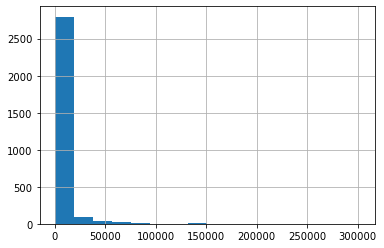

In [65]:
#Revenue
rev = OL_Data.groupby('seller_id').Total_payment.sum().reset_index()
rev.columns = ['SellerID','Seller_Revenue']

sellers = pd.merge(sellers, rev, on='SellerID')

print(sellers['Seller_Revenue'].describe())
sellers.Seller_Revenue.sort_values().hist(bins=16)
plt.show()

Seller_Recency


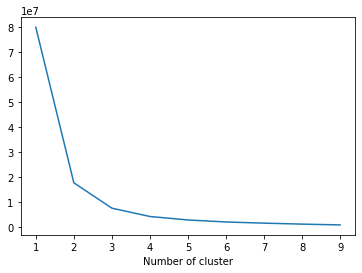


Seller_Frequency


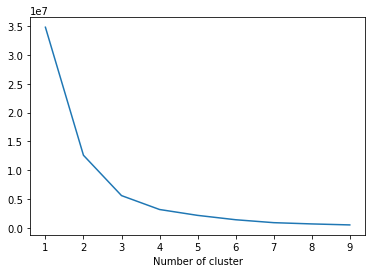


Seller_Revenue


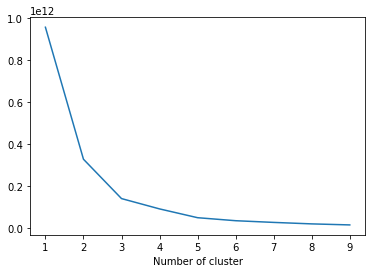

In [66]:
print('Seller_Recency')
PrintKmeansInertiaGraph(sellers,'Seller_Recency')
print('')
print('Seller_Frequency')
PrintKmeansInertiaGraph(sellers,'Seller_Frequency')
print('')
print('Seller_Revenue')
PrintKmeansInertiaGraph(sellers,'Seller_Revenue')

In [67]:
#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(sellers,'Seller_Recency', 4)
#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
sellers = clustersInOrder('Seller_RecencyCluster', 'Seller_Recency', sellers, True)

#Generate Recency Clusters, named 'FrequencyCluster'
PerformKMeans(sellers,'Seller_Frequency', 4)
#Reset Cluster Names, Higher Frequency = More Frequent, Higher Frequency Cluster
sellers = clustersInOrder('Seller_FrequencyCluster', 'Seller_Frequency', sellers, True)

#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(sellers,'Seller_Revenue', 5)
#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
sellers = clustersInOrder('Seller_RevenueCluster', 'Seller_Revenue', sellers, True)

In [68]:
#calculate overall score and use mean() to see details
sellers['Seller_OverallRFMScore'] = sellers['Seller_RecencyCluster'] + sellers['Seller_FrequencyCluster'] + sellers['Seller_RevenueCluster']
print(sellers.groupby('Seller_OverallRFMScore')[['Seller_Recency','Seller_Frequency','Seller_Revenue']].mean())

print(sellers.groupby('Seller_OverallRFMScore')[['Seller_Revenue']].count())

                        Seller_Recency  Seller_Frequency  Seller_Revenue
Seller_OverallRFMScore                                                  
0                            29.443636         12.887273     2054.360429
1                           119.894574         20.308527     4305.321240
2                           228.179348         40.547101     6442.103949
3                           441.169096         36.568513     7063.837813
4                            84.256410        337.076923    48214.016410
5                            80.400000        557.900000   114049.226000
6                             7.375000       1187.125000   175086.316250
7                            10.600000       1252.600000   254983.110000
                        Seller_Revenue
Seller_OverallRFMScore                
0                                 1375
1                                  645
2                                  552
3                                  343
4                                   

In [69]:
sellers['Seller_RFM_Ranking'] = 'Lowest'
sellers.loc[sellers['Seller_OverallRFMScore']>=1,'Seller_RFM_Ranking'] ='Low' 
sellers.loc[sellers['Seller_OverallRFMScore']>=4, 'Seller_RFM_Ranking'] = 'Medium'
sellers.loc[sellers['Seller_OverallRFMScore']>=6, 'Seller_RFM_Ranking'] = 'High'

In [75]:
OL_Data = OL_Data.merge(buyers, left_on='customer_unique_id', right_on='CustomerUniqueID')
OL_Data = OL_Data.merge(sellers, left_on='seller_id',right_on='SellerID')
OL_Data.columns

Index(['Unnamed: 0', 'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'shipping_limit_date', 'payment_installments',
       'product_category_name_english', 'seller_id', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'seller_latitude', 'seller_longitude',
       'customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'customer_latitude',
       'customer_longitude', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp', 'Total_price',
       'number_of_items', 'Median_payments', 'Total_payment', 'Total_Freight',
       'order_weight_g', 'order_volume_cm3', 'payment_type',
       'Purchase_To_Delivery_Days', 'Approved_To_Delivery_Days',
       'Diff_Est_Delivery_vs_Actual', 'CustomerUniqueID_x', 'Buyer_Recency_x',
       'Buyer_RecencyCluster_x

In [89]:

#calculate Distance Between Two Points on Earth
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     
OL_Data['DistanceOfSale'] = OL_Data.apply(lambda x: distance(x.customer_latitude, x.customer_longitude, x.seller_latitude, x.seller_longitude) , axis=1)

In [90]:
OL_Data['DistanceOfSale'].describe()

count    99727.000000
mean       603.487296
std        596.949713
min          0.000000
25%        189.670210
50%        435.533645
75%        801.451936
max       8736.947618
Name: DistanceOfSale, dtype: float64

In [74]:
OL_Data.to_csv('./OLData_RFM_Metrics.csv')